# Export video using ArcGIS API for Python

## Table of Contents
* [Introduction](#Introduction)
* [Necessary Imports](#Necessary-Imports)
* [Connect to your GIS](#Connect-to-your-GIS)
* [Get the data for analysis](#Get-the-data-for-analysis)
* [Function to create collection of images with desired time intervals](#Function-to-create-collection-of-images-with-desired-time-intervals)
* [Make video from image collection](#Make-video-from-image-collection)

# Introduction

World is changing daily. Major changes like shrinking of lakes, river path shifts, construction of megastructures can be seen directly from the satellite images. This notebooks intends to showcase the capabilities of ArcGIS Python API to create a movie based on the area of extent provided.

# Necessary Imports

In [4]:
import os
import imageio
import datetime as dt
import pandas as pd
from PIL import Image, ImageFont,  
from PIL import ImageFont
from PIL import ImageDraw

import arcgis
from arcgis.gis import GIS
from arcgis import geometry
from arcgis.raster.functions import apply

# Connect to your GIS

In [3]:
gis = GIS("your_enterprise_profile")

# Get the data for analysis

Seach for Multispectral Landsat layer in ArcGIS Online.

<Item title:"Multispectral Landsat" type:Imagery Layer owner:esri>
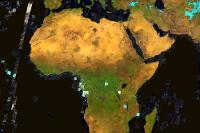

In [4]:
def exact_search(my_gis, title, owner_value, item_type_value):
    final_match = None
    search_result = my_gis.content.search(query= title + ' AND owner:' + owner_value,
                                          item_type=item_type_value,
                                          outside_org=True)
    
    if "Imagery Layer" in item_type_value:
        item_type_value = item_type_value.replace("Imagery Layer", "Image Service")
    elif "Layer" in item_type_value:
        item_type_value = item_type_value.replace("Layer", "Service")
    
    for result in search_result:
        if result.title == title and result.type == item_type_value:
            final_match = result
            break
    return final_match

landsat_item = exact_search(gis, 'Multispectral Landsat', 'esri', 'Imagery Layer')
landsat = landsat_item.layers[0]
landsat_item

Applying Natural color to the filtered Landsat collection using predefined `apply` function

In [5]:
rgb_collection = apply(landsat, 'Natural Color with DRA')

In [18]:
extent= {'xmin': 9290111.11700088,             # set the extent of the area
        'ymin': 2437011.48346161,
        'xmax': 9369306.09642573,
        'ymax': 2506091.46056388}

## Function to create collection of images with desired time intervals

The function below creates an array of images with the desired time intervals. If a user specifies 'm' then the images in the selected collection will be consolidated on a monthly basis i.e. all the images of the specified extent will be mosaicked monthly and if the user specifies 'y' as the interval then the images in the selected collection will be consolidated on yearly basis.

In [7]:
def collection(df, interval, start, end, height, width):
    images=[]
    if(interval=='m'):                                                                                     # monthly
        for i in range(int(start.split('-')[0]), int(end.split('-')[0])+1):
            for j in range(1,13):
                selected = df[(df['AcquisitionDate'].dt.year == i) & (df['AcquisitionDate'].dt.month == j)]
                id = selected['OBJECTID'].values.tolist()
                if(len(id)>0):
                    rgb_collection.mosaic_by(method="LockRaster",lock_rasters=id)
                    img_name = 'img_'+str(i)+"-"+str(j)+".jpg"
                    rgb_collection.export_image(bbox=extent, size=[height,width], f='image', 
                                                  save_folder='.', 
                                                  save_file=img_name)
                    img = Image.open(img_name).convert('RGB')
                    draw = ImageDraw.Draw(img)
                    draw.text((550, 0),str(j)+"-"+str(i),(255,255,255))
                    images.append(img)
                    os.remove(img_name)
                    
    elif(interval=='y'):                                                                                  # yearly
        for i in range(int(start.split('-')[0]), int(end.split('-')[0])+1):
            selected = df[df['AcquisitionDate'].dt.year == i]
            id = selected['OBJECTID'].values.tolist()
            if(len(id)>0):
                rgb_collection.mosaic_by(method="LockRaster",lock_rasters=id)
                img_name = 'img_'+str(i)+".jpg"
                rgb_collection.export_image(bbox=extent, size=[height,width], f='image', 
                                              save_folder='.', 
                                              save_file=img_name)
                img = Image.open(img_name).convert('RGB')
                draw = ImageDraw.Draw(img)
                draw.text((550, 0),str(i),(255,255,255))    
                images.append(img)
                os.remove(img_name)
    
    return images

## Make video from image collection

The function below will generate a movie (gif) from the collection saved from the above step.

In [8]:
def create_movie(target, interval, start, end, height, width, extent, duration):
    start_date = dt.datetime.strptime(start, '%Y-%m-%d')
    end_date = dt.datetime.strptime(end, '%Y-%m-%d')
    selected = target.filter_by(where="(Category = 1) AND (CloudCover <=0.1)",
                             time=[start_date, end_date],
                             geometry=arcgis.geometry.filters.intersects(extent))

    df = selected.query(out_fields="AcquisitionDate, GroupName, CloudCover, DayOfYear", 
                        order_by_fields="AcquisitionDate").sdf
    df['AcquisitionDate'] = pd.to_datetime(df['AcquisitionDate'], unit='ms')
    frames = collection(df, interval, start, end, height, width)
    imageio.mimsave('movie'+'_'+interval+'.gif', frames, duration=duration)
    print("Movie Created")

In [19]:
create_movie(rgb_collection,'m' ,'2017-01-01','2019-12-31', 1250, 450, extent, 0.4)          # calling create_movie function

Movie Created


![SegmentLocal](../../static/img/movie_m.gif "segment")